In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import uproot
import awkward as ak

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Function to calculate weights analytically

def weight_fn(thetas, angles):
    theta0, theta1, theta2 = thetas[:, 0], thetas[:, 1], thetas[:, 2]
    phi, costh = angles[:, 0], angles[:, 1]
    weight = 1. + theta0* costh * costh + 2.* theta1* costh * np.sqrt(1. - costh * costh) * np.cos(phi) + 0.5* theta2* (1. - costh * costh)* np.cos(2. * phi)
    return weight / (1. + costh * costh)

In [4]:
# Load E906 Simulated data

nevents = 10**6

tree = uproot.open("BMFData.root:save")
events = tree.arrays(["mass", "pT", "xF", "phi", "costh", "true_phi", "true_costh"])

X = np.array([(mass, pT, xF, phi, costh) for mass, pT, xF, phi, costh in zip(events.mass, events.pT, events.xF, events.phi, events.costh)])
Y = np.array([(true_phi, true_costh) for true_phi, true_costh in zip(events.true_phi, events.true_costh)])

# Fast Simulation using Variational Autoencoders

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=nevents, shuffle=True)

thetas = np.random.uniform(-1., 1, (nevents, 3))

W_train = weight_fn(thetas, Y_train).reshape(-1, 1)

In [6]:
# Some const.

batch_size = 1024
num_epochs = 100

In [7]:
# Convert to torch tensor

X_tensor = torch.from_numpy(X_train).float()
weight_tensor = torch.from_numpy(W_train).float()

dataset = TensorDataset(X_tensor, weight_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Define the Variational Autoencoder (VAE) architecture

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.fc_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=True),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim, bias=True),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim, bias=True)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim, bias=True)

        self.fc_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim, bias=True),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim, bias=True),
        )
        
    def encode(self, x):
        h = self.fc_encoder(x)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        return mu, logvar
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
        
    def decode(self, z):
        h = self.fc_decoder(z)
        return h
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [9]:
# Define the loss function (VAE loss)

def vae_loss(reco_x, x, weight, mu, logvar):
    reco_loss = (weight* (reco_x - x)* (reco_x - x)).sum()
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (reco_loss + kld_loss)/ x.size(0)

In [10]:
# Create the VAE
input_dim = 5
hidden_dim = 512
latent_dim = 20
vae = VAE(input_dim, hidden_dim, latent_dim)

In [11]:
# Define the optimizer
optimizer = optim.Adam(vae.parameters(), lr=0.0001)

In [12]:
# Training loop
for epoch in range(num_epochs):
    vae.train()
    for batch_data, batch_weight in dataloader:
        optimizer.zero_grad()
        recon_data, mu, logvar = vae(batch_data)  # Use batch_data
        loss = vae_loss(recon_data, batch_data, batch_weight, mu, logvar)  # Use batch_data and batch_weight
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"===> Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}")

===> Epoch [0/100], Loss: 2.3550078868865967
===> Epoch [10/100], Loss: 1.9808392524719238
===> Epoch [20/100], Loss: 2.019901752471924
===> Epoch [30/100], Loss: 2.0057616233825684
===> Epoch [40/100], Loss: 2.0122833251953125
===> Epoch [50/100], Loss: 1.960410237312317
===> Epoch [60/100], Loss: 1.9490818977355957
===> Epoch [70/100], Loss: 1.9979913234710693
===> Epoch [80/100], Loss: 1.940956950187683
===> Epoch [90/100], Loss: 2.011509418487549


In [13]:
num_samples = 10**5

X_test1, X_test2, Y_test1, Y_test2 = train_test_split(X_test, Y_test, train_size=num_samples, shuffle=True)


thetas_test = np.random.uniform(-1., 1., (num_samples, 3))

weights = weight_fn(thetas_test, Y_test1)

In [14]:
vae.eval()
with torch.no_grad():
    # background_subtracted_data, _, _ = vae(torch.Tensor(X))
    background_subtracted_data = vae.decode(torch.randn(num_samples, latent_dim)).float()

background_subtracted_data = background_subtracted_data.detach().numpy()

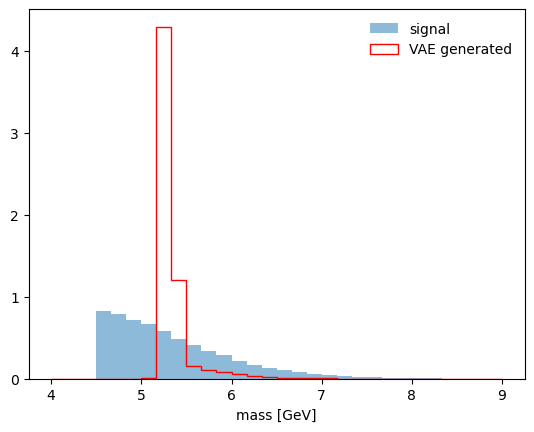

In [15]:
bins = np.linspace(4.0, 9.0, 31)

plt.hist(X_test1[:, 0], bins=bins, weights=weights, alpha=0.5, label="signal", density=True)
plt.hist(background_subtracted_data[:, 0], bins=bins, label="VAE generated", histtype="step", color="red", density=True)
plt.xlabel("mass [GeV]")
plt.legend(frameon=False)
# plt.savefig("notes/08-01-2023/imgs/fast_sim_04.png")
plt.show()

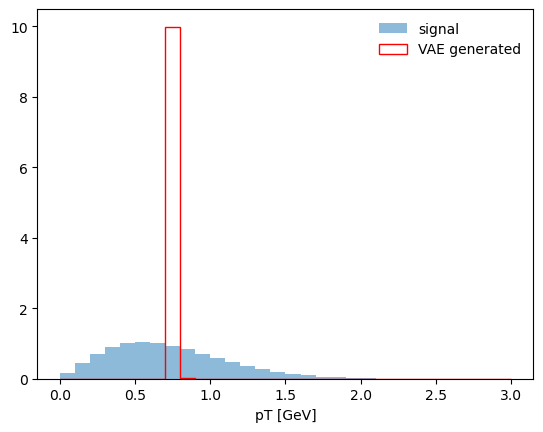

In [16]:
bins = np.linspace(0.0, 3.0, 31)

plt.hist(X_test1[:, 1], bins=bins, weights=weights, alpha=0.5, label="signal", density=True)
plt.hist(background_subtracted_data[:, 1], bins=bins, label="VAE generated", histtype="step", color="red", density=True)
plt.xlabel("pT [GeV]")
plt.legend(frameon=False)
# plt.savefig("notes/08-01-2023/imgs/fast_sim_05.png")
plt.show()

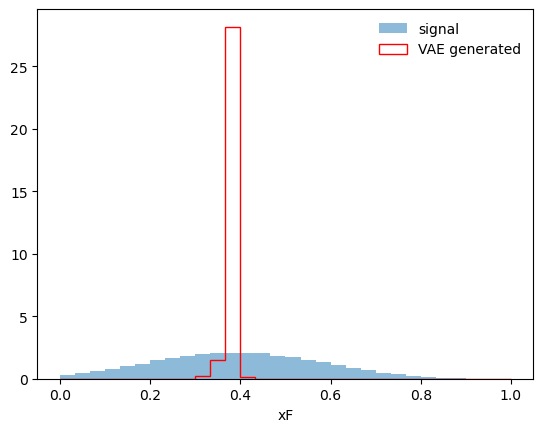

In [17]:
bins = np.linspace(0.0, 1.0, 31)

plt.hist(X_test1[:, 2], bins=bins, weights=weights, alpha=0.5, label="signal", density=True)
plt.hist(background_subtracted_data[:, 2], bins=bins, label="VAE generated", histtype="step", color="red", density=True)
plt.xlabel("xF")
plt.legend(frameon=False)
# plt.savefig("notes/08-01-2023/imgs/fast_sim_06.png")
plt.show()

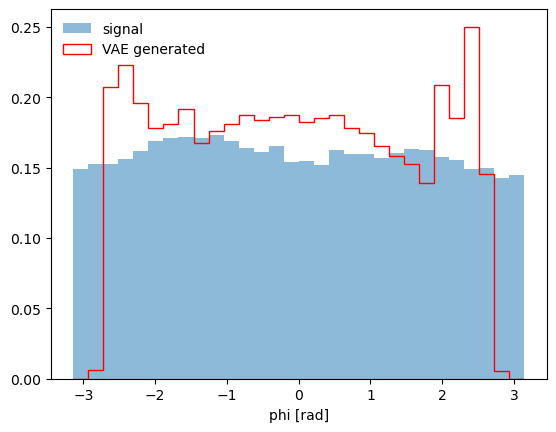

In [18]:
bins = np.linspace(-np.pi, np.pi, 31)

plt.hist(X_test1[:, 3], bins=bins, weights=weights, alpha=0.5, label="signal", density=True)
plt.hist(background_subtracted_data[:, 3], bins=bins, label="VAE generated", histtype="step", color="red", density=True)
plt.xlabel("phi [rad]")
plt.legend(frameon=False)
# plt.savefig("notes/08-01-2023/imgs/fast_sim_07.png")
plt.show()

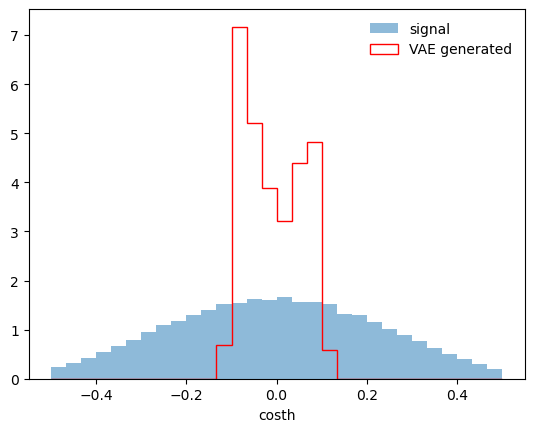

In [19]:
bins = np.linspace(-0.5, 0.5, 31)

plt.hist(X_test1[:, 4], bins=bins, weights=weights, alpha=0.5, label="signal", density=True)
plt.hist(background_subtracted_data[:, 4], bins=bins, label="VAE generated", histtype="step", color="red", density=True)
plt.xlabel("costh")
plt.legend(frameon=False)
# plt.savefig("notes/08-01-2023/imgs/fast_sim_08.png")
plt.show()

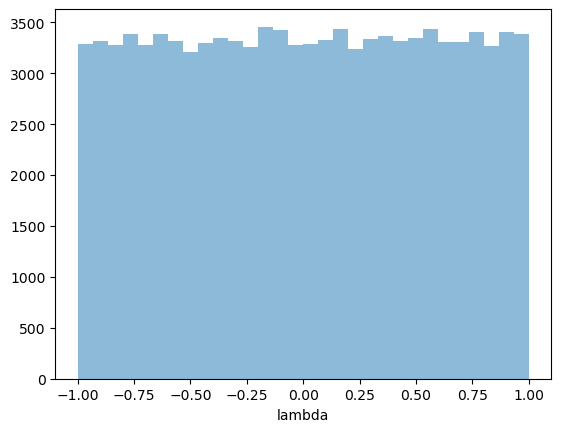

In [20]:
bins = np.linspace(-1., 1., 31)

plt.hist(thetas_test[:, 0], bins=bins, alpha=0.5)
plt.xlabel("lambda")
# plt.savefig("notes/08-01-2023/imgs/fast_sim_01.png")
plt.show()

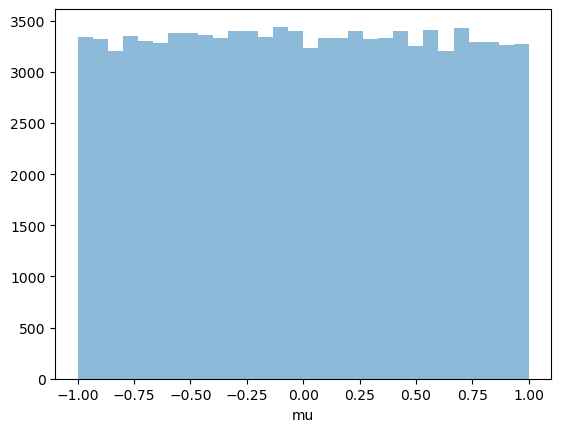

In [21]:
bins = np.linspace(-1., 1., 31)

plt.hist(thetas_test[:, 1], bins=bins, alpha=0.5)
plt.xlabel("mu")
# plt.savefig("notes/08-01-2023/imgs/fast_sim_02.png")
plt.show()

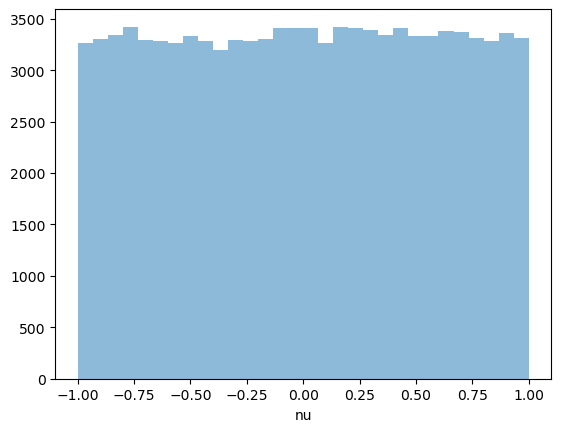

In [22]:
bins = np.linspace(-1., 1., 31)

plt.hist(thetas_test[:, 2], bins=bins, alpha=0.5)
plt.xlabel("nu")
# plt.savefig("notes/08-01-2023/imgs/fast_sim_03.png")
plt.show()